In [23]:
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import math
import numpy as np

In [205]:
url_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC"
gares = requests.get(url_gares)
wb_gares = gares.json()

df_gares = pd.DataFrame(wb_gares)
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [194]:
url_freq_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC"
freq_gares = requests.get(url_freq_gares)
wb_freq_gares = freq_gares.json()

df_freq_gares = pd.DataFrame(wb_freq_gares)
df_freq_gares.head(2)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121


In [174]:
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [175]:
#nous avons plus de données sur les gares que sur la frequentation
print(len(df_gares))
print(len(df_freq_gares))

3819
2970


In [176]:
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]

In [177]:
#pour regarder quelles gares ne sont pas dans la database qui contient les frequentations
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']]
#ce sont de petites gares donc on va considérer seulement celles de la database des frequentations

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir
35,87271320,La Courneuve-Dugny
39,87172411,Margut-Fromy
49,87172593,Vouziers
...,...,...
3785,87286807,Genech
3793,87755835,La Motte-Ste-Rosseline
3799,87729210,Port-Fluvial-de-Chalon-sur-Saône
3801,87286252,Rougebarre


(array([3.271e+03, 1.100e+01, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00]),
 array([1.00000000e+00, 1.52624522e+07, 3.05249034e+07, 4.57873546e+07,
        6.10498058e+07, 7.63122570e+07, 9.15747082e+07, 1.06837159e+08,
        1.22099611e+08, 1.37362062e+08, 1.52624513e+08]),
 <BarContainer object of 10 artists>)

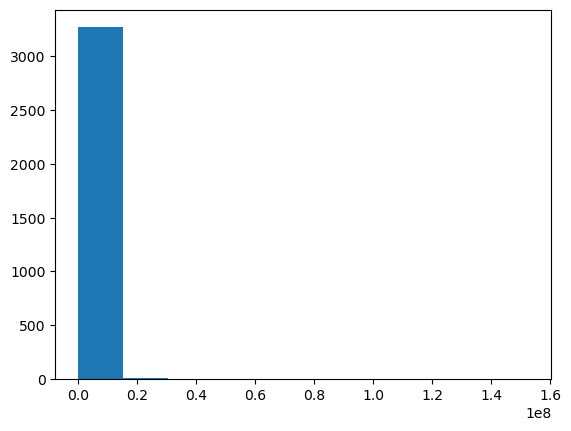

In [178]:
#gérer les cas 0 et NaN --> pour 0, on les enlève (petites gares) mais il faudra gérer le cas NaN qui contient Paris Est

df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])

(array([ 16.,  32.,  92., 259., 639., 944., 774., 403., 121.,  11.]),
 array([ 0.        ,  1.88434913,  3.76869826,  5.65304739,  7.53739652,
         9.42174565, 11.30609478, 13.19044391, 15.07479304, 16.95914217,
        18.8434913 ]),
 <BarContainer object of 10 artists>)

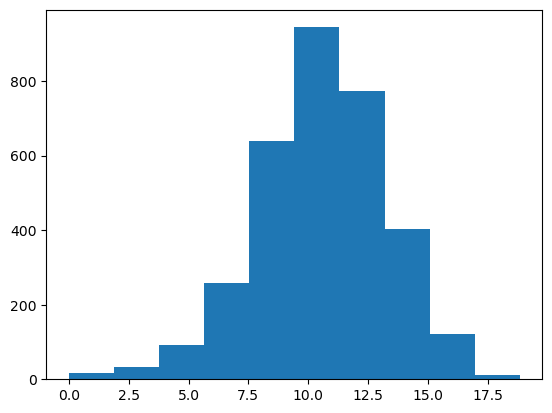

In [195]:
df_gares_merged['log_total_voyageurs_non_voyageurs_2020'] = np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.hist(df_gares_merged['log_total_voyageurs_non_voyageurs_2020'])
#mieux pour travailler sur les frequentations

In [180]:
#filtre sur les frequentations : on ne garde que les plus grosses gares
df_gares_principales = df_gares_merged[df_gares_merged['log_total_voyageurs_non_voyageurs_2020']>= 14]
#on regarde les gares pour lesquelles il nous manque les coordonnees gps
df_gares_principales[df_gares_principales['x_wgs84'].isna()==True]


,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
382,87758607,7980634,Châtelet les Halles,NaN,NaN,15.892528
637,87756403,4085871,Monaco-Monte-Carlo,NaN,NaN,15.223045
975,87113209,3862190,Pantin,NaN,NaN,15.166745
979,87758904,107666015,Paris Gare du Nord,NaN,NaN,18.494545
1069,87654798,2865667,Rosa Parks,NaN,NaN,14.868312
1074,87113696,3206275,Rosny Bois Perrier,NaN,NaN,14.980620
1163,87113795,3664906,Villiers-sur-Marne - Le Plessis-Trévise,NaN,NaN,15.114313
1293,87116046,2496908,Émerainville - Pontault-Combault,NaN,NaN,14.730564
1810,87113704,2380920,Rosny-sous-Bois,NaN,NaN,14.682998
2325,87113522,1562549,Le Chénay Gagny,NaN,NaN,14.261829


In [181]:
#on sort les donnees manquantes du dataframe, on va les chercher grace a d'autres sources de donnees
df_gares_principales = df_gares_principales.dropna()

In [182]:
#on recupere les donnees manquantes (sauf monaco, mais pas vrmt en France) grace à l'API de la region idf
url_region_idf = "https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-stations-du-reseau-ferre-schematique-dile-de-france-petit-format/exports/json?limit=-1&offset=0&timezone=UTC"
region_idf = requests.get(url_region_idf)
wb_region_idf = region_idf.json()

df_region_idf = pd.DataFrame(wb_region_idf)

gares_manquantes = ["CHATELET-LES HALLES", "PANTIN", "GARE DU NORD", "ROSA PARKS", "ROSNY-BOIS-PERRIER", "VILLIERS-SUR-MARNE-PLESSIS-TREVISE", "EMERAINVILLE-PONTAULT-COMBAULT", "ROSNY-SOUS-BOIS", "CHENAY-GAGNY", "ROISSY-EN-BRIE", "LES BOULLEREAUX-CHAMPIGNY", "NOGENT-LE-PERREUX", "GARE DE L'EST", "VAL-DE-FONTENAY"]

df_region_idf = df_region_idf[df_region_idf.nom_gare.isin(gares_manquantes)==True]
#suppression des doublons (lorsque différents trains passent à une même gare en idf)
df_region_idf.drop_duplicates(subset ="nom_gare", keep = 'first', inplace=True)

df_region_idf.reset_index(inplace = True)
df_region_idf = df_region_idf.drop(['index'], axis=1)

In [196]:
#recuperation des donnees gps pour la nouvelle base de donnees
longitude = [0]*len(df_region_idf)
latitude = [0]*len(df_region_idf)

for i in range(len(df_region_idf)):
    longitude[i] = df_region_idf['geo_point_2d'][i]['lon']
    latitude[i] = df_region_idf['geo_point_2d'][i]['lat']

df_region_idf['y_wgs84']=latitude
df_region_idf['x_wgs84']=longitude


In [184]:
m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
for i in df_gares_principales.index:
    tooltip = df_gares_principales['nom_gare'][i]
    folium.Marker([df_gares_principales['y_wgs84'][i],df_gares_principales['x_wgs84'][i]], popup=df_gares_principales['nom_gare'][i], tooltip=tooltip).add_to(m)
m

In [206]:
m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
for i in df_region_idf.index:
    tooltip = df_region_idf['nom_gare'][i]
    folium.Marker([df_region_idf['y_wgs84'][i],df_region_idf['x_wgs84'][i]], popup=df_region_idf['nom_gare'][i], tooltip=tooltip).add_to(m)
m
#probleme --> les coordonnes semblent mauvaises